In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Loading functions
import os
from monai.networks.nets import SwinUNETR
from functools import partial

import torch
import torch.nn.parallel
import logging
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)
import torch
import wandb



# Funciones de carga y preprocesameinto

In [3]:
#Transformaciones
val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys="image"), #Leer imagenes    
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True), #Normalizar intensidades
    ]
)

# Dado un arreglo de paths de imagenes devuelve un tensor torch.Size([canales, x, y, z])
def get_image_data(image, transform):
    data = transforms.apply_transform(
                transform,
                data= {"image":image},
            )
    return data["image"]   
    


# Funciones para aplicar la inferencia y obtener las segmentaciones

# Crear el modelo y asignarle los pesos

In [5]:
######################
# Crear el modelo
######################

### Hyperparameter
roi = (128, 128, 64)  # (128, 128, 128)

# Create Swin transformer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=10,
    out_channels=2,  # mdificar con edema
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)



c:\Users\Cecilia\anaconda3\envs\monai_env\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [6]:
run = wandb.init()
artifact = run.use_artifact('mlops-team89/Swin_UPENN_106cases/ip0bojmx_best_model:v0', type='model')
artifact_dir = artifact.download()
print(artifact_dir)

# model.to(device)
# model.load_state_dict(torch.load(os.path.join("./trained", "best_metric_model.pth"), map_location=torch.device('cpu')))
# model.eval()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: muletdelosreyes89 (mlops-team89). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact ip0bojmx_best_model:v0, 244.52MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


.\artifacts\ip0bojmx_best_model-v0


In [7]:
#model.load_state_dict(torch.load(os.path.join(artifact_dir, "model.pt"), map_location=torch.device('cpu')))

model_path = os.path.join(artifact_dir, "model.pt")
#model_path = os.path.join('./trained_models', "model.pt")

# Load the model on CPU
loaded_model = torch.load(model_path, map_location=torch.device('cpu'))["state_dict"]

# Load the state dictionary into the model
model.load_state_dict(loaded_model)

# Move the model to the desired device (e.g., GPU) if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(10, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_featur

# Cargar las imágenes

In [8]:
import glob
# Path de las imágenes para hacer la inferencia
T1_path="./Dataset/UPENN-GBM-00002_11/UPENN-GBM-00002_11_T1.nii.gz"
T2_path="./Dataset/UPENN-GBM-00002_11/UPENN-GBM-00002_11_T2.nii.gz"
Flair_path="./Dataset/UPENN-GBM-00002_11/UPENN-GBM-00002_11_FLAIR.nii.gz"
T1GDT_path="./Dataset/UPENN-GBM-00002_11/UPENN-GBM-00002_11_T1GD.nii.gz"

# Formar el vector de imágenes y realizar la transformación
def obtener_imagen(dataset, img_n):
    
    # DSC images
    DSC_ap_rCBV_list = sorted(glob.glob(f"{dataset}/images_DSC/UPENN-GBM-*/*_11_DSC_ap-rCBV.nii.gz"))
    DSC_PH_list = sorted(glob.glob(f"{dataset}/images_DSC/UPENN-GBM-*/*_11_DSC_PH.nii.gz"))
    DSC_PSR_list = sorted(glob.glob(f"{dataset}/images_DSC/UPENN-GBM-*/*_11_DSC_PSR.nii.gz"))
    # DTI images
    DTI_AD_list = sorted(glob.glob(f"{dataset}/images_DTI/UPENN-GBM-*/*_11_DTI_AD.nii.gz"))
    DTI_FA_list = sorted(glob.glob(f"{dataset}/images_DTI/UPENN-GBM-*/*_11_DTI_FA.nii.gz"))
    DTI_RD_list = sorted(glob.glob(f"{dataset}/images_DTI/UPENN-GBM-*/*_11_DTI_RD.nii.gz"))
    DTI_TR_list = sorted(glob.glob(f"{dataset}/images_DTI/UPENN-GBM-*/*_11_DTI_TR.nii.gz"))
    # Structural images
    FLAIR_list = sorted(glob.glob(f"{dataset}/images_structural/UPENN-GBM-*/*_11_FLAIR.nii.gz"))
    T1_list = sorted(glob.glob(f"{dataset}/images_structural/UPENN-GBM-*/*_11_T1.nii.gz"))
    # T1GD_list = sorted(glob.glob(f"{dataset}/images_structural/UPENN-GBM-*/*_11_T1GD.nii.gz"))
    T2_list = sorted(glob.glob(f"{dataset}/images_structural/UPENN-GBM-*/*_11_T2.nii.gz"))

    images=[DSC_ap_rCBV_list[img_n], DSC_PH_list[img_n], DSC_PSR_list[img_n], 
            DTI_AD_list[img_n], DTI_FA_list[img_n], DTI_RD_list[img_n], DTI_TR_list[img_n], 
            FLAIR_list[img_n], T1_list[img_n], T2_list[img_n]] # Deben respetar este orden - T1GD_list[img_n]
    
    directory = os.path.dirname(FLAIR_list[img_n])
    print(images)

    template = nib.load(images[0])
    header, affine = template.header, template.affine

    image_data=get_image_data(images, val_transform)
    #print(image_data.shape)
    return image_data, header, affine, directory

img_n=5
dataset="./Dataset/Dataset_106_30_casos/test/images"
image_data, header, affine, directory = obtener_imagen(dataset, img_n)

['./Dataset/Dataset_106_30_casos/test/images/images_DSC\\UPENN-GBM-00055_11\\UPENN-GBM-00055_11_DSC_ap-rCBV.nii.gz', './Dataset/Dataset_106_30_casos/test/images/images_DSC\\UPENN-GBM-00055_11\\UPENN-GBM-00055_11_DSC_PH.nii.gz', './Dataset/Dataset_106_30_casos/test/images/images_DSC\\UPENN-GBM-00055_11\\UPENN-GBM-00055_11_DSC_PSR.nii.gz', './Dataset/Dataset_106_30_casos/test/images/images_DTI\\UPENN-GBM-00055_11\\UPENN-GBM-00055_11_DTI_AD.nii.gz', './Dataset/Dataset_106_30_casos/test/images/images_DTI\\UPENN-GBM-00055_11\\UPENN-GBM-00055_11_DTI_FA.nii.gz', './Dataset/Dataset_106_30_casos/test/images/images_DTI\\UPENN-GBM-00055_11\\UPENN-GBM-00055_11_DTI_RD.nii.gz', './Dataset/Dataset_106_30_casos/test/images/images_DTI\\UPENN-GBM-00055_11\\UPENN-GBM-00055_11_DTI_TR.nii.gz', './Dataset/Dataset_106_30_casos/test/images/images_structural\\UPENN-GBM-00055_11\\UPENN-GBM-00055_11_FLAIR.nii.gz', './Dataset/Dataset_106_30_casos/test/images/images_structural\\UPENN-GBM-00055_11\\UPENN-GBM-00055_

# Correr inferencia y visualizar salidas

In [53]:
post_trans = transforms.Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)] # argmax=True / threshold=0.5
)

def inference(input, model):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )
    return _compute(input)
    
roi_t= (224, 224, 128)
model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi_t[0], roi_t[1], roi_t[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
) 

# hacer inferencia
def inferir(image_data, model):
        
    with torch.no_grad():
        val_input = image_data.unsqueeze(0).to(device)
        print(val_input.shape)
        val_output = inference(val_input, model) # inference(val_input, model) - model_inferer_test(val_input)
        val_output = post_trans(val_output[0])
        print("Inferencia realizada")
    return val_output

def save_img(I_img,savename,header=None,affine=None):
    if header is None or affine is None:
        affine = np.diag([1, 1, 1, 1])
        new_img = nib.nifti1.Nifti1Image(I_img, affine, header=None)
    else:
        new_img = nib.nifti1.Nifti1Image(I_img, affine, header=header)

    nib.save(new_img, savename)

In [54]:
val_output = inferir(image_data, model)

torch.Size([1, 10, 240, 240, 155])
Inferencia realizada


In [76]:
prob_sig = torch.sigmoid(val_output )
print(prob_sig.shape)
seg = prob_sig[0].detach().cpu().numpy()
print(seg.shape)
seg1 = (seg > 0.5).astype(np.int8)
seg_out = np.zeros((seg1.shape[1], seg1.shape[2], seg1.shape[3]))
seg_out[seg1[1] == 1] = 1
seg_out[seg1[0] == 1] = 3
# Nueva línea para la intersección utilizando 'and'
seg_out[(seg1[0] == 1) & (seg1[1] == 1)] = 2

torch.Size([1, 2, 240, 240, 155])
(2, 240, 240, 155)


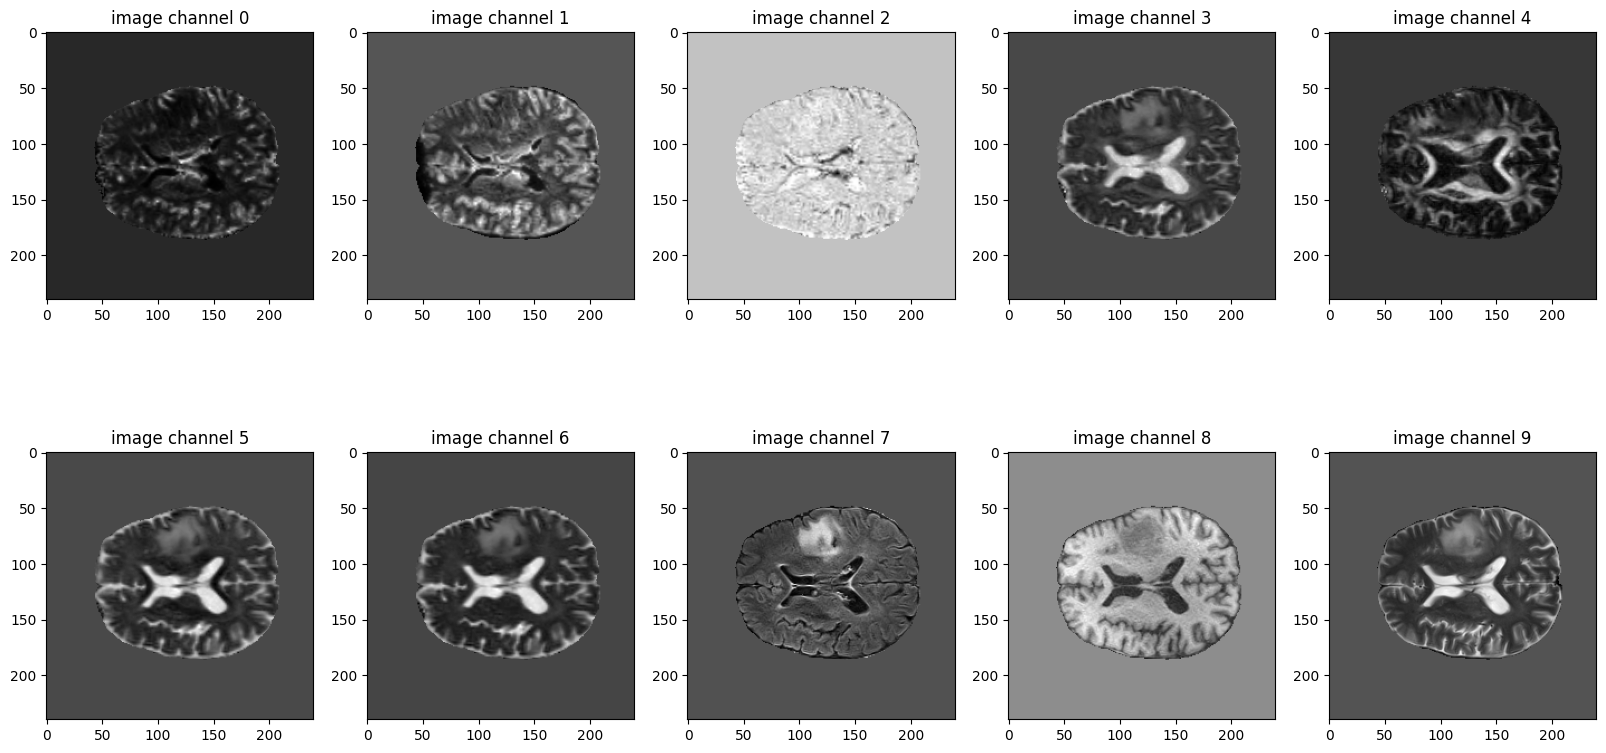

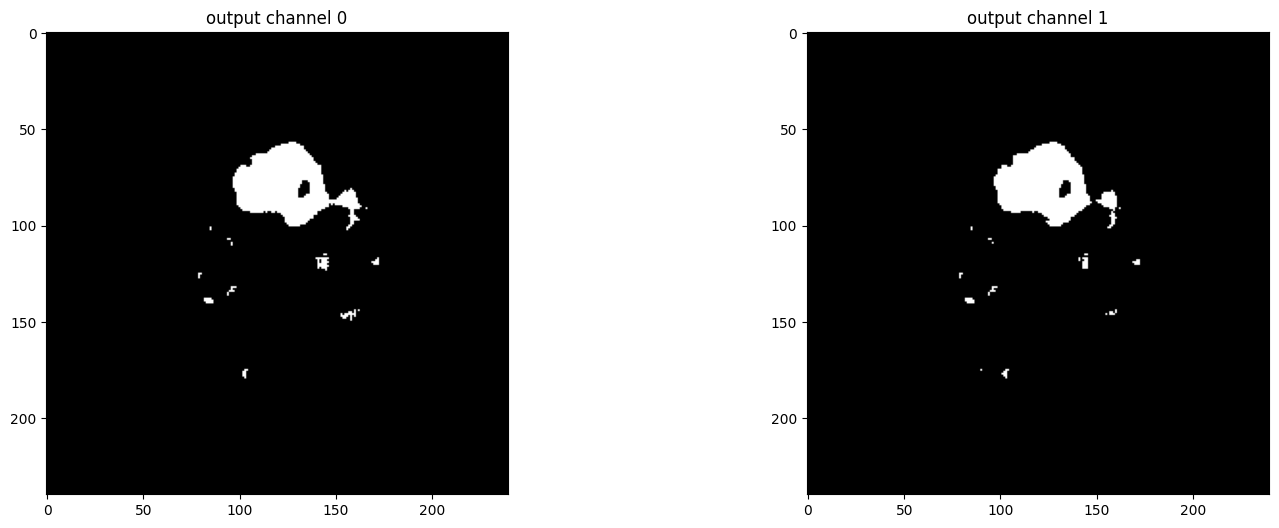

In [77]:
sl=80

plt.figure("image", (20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(image_data[i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()
# visualize the 3 channels model output corresponding to this image
plt.figure("output", (18, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(f"output channel {i}")
    plt.imshow(seg1[i, :, :, sl], cmap="gray") #.detach().cpu()
plt.show()

In [108]:
# Crear un nuevo tensor de ceros con el tamaño deseado
output_tensor = torch.zeros(240, 240, 155, dtype=torch.float32)

output_tensor += val_output[1] * 2  # necrosis
output_tensor += val_output[0] * 3 # edema
output_tensor += val_output[2] * 4  # activo

save_img(
            output_tensor.numpy(),
            f"{directory}/{img_n}segmentation.nii.gz",
            header,
            affine,
        )
output_tensor.shape

torch.Size([240, 240, 155])

In [109]:
dataset="./Dataset/recurrence/images_structural"
for img_n in range(36):
    image_data, header, affine, directory = obtener_imagen(dataset, img_n)
    val_output = inferir(image_data, model)

    output_tensor = torch.zeros(240, 240, 155, dtype=torch.float32)
    output_tensor += val_output[1] * 2  # necrosis
    output_tensor += val_output[0] * 3 # edema
    output_tensor += val_output[2] * 4  # activo


    save_img(
            output_tensor.numpy(),
            f"{directory}/{img_n}segmentation.nii.gz",
            header,
            affine,
        )
    print(f"Image {img_n} saved at {directory}")

['./Dataset/recurrence/images_structural\\UPENN-GBM-00036_21\\UPENN-GBM-00036_21_FLAIR.nii.gz', './Dataset/recurrence/images_structural\\UPENN-GBM-00036_21\\UPENN-GBM-00036_21_T1.nii.gz', './Dataset/recurrence/images_structural\\UPENN-GBM-00036_21\\UPENN-GBM-00036_21_T1GD.nii.gz', './Dataset/recurrence/images_structural\\UPENN-GBM-00036_21\\UPENN-GBM-00036_21_T2.nii.gz']
Inferencia realizada
Image 0 saved at ./Dataset/recurrence/images_structural\UPENN-GBM-00036_21
['./Dataset/recurrence/images_structural\\UPENN-GBM-00042_21\\UPENN-GBM-00042_21_FLAIR.nii.gz', './Dataset/recurrence/images_structural\\UPENN-GBM-00042_21\\UPENN-GBM-00042_21_T1.nii.gz', './Dataset/recurrence/images_structural\\UPENN-GBM-00042_21\\UPENN-GBM-00042_21_T1GD.nii.gz', './Dataset/recurrence/images_structural\\UPENN-GBM-00042_21\\UPENN-GBM-00042_21_T2.nii.gz']
Inferencia realizada
Image 1 saved at ./Dataset/recurrence/images_structural\UPENN-GBM-00042_21
['./Dataset/recurrence/images_structural\\UPENN-GBM-00045_21